In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, lib
from dotenv import load_dotenv
import typing

load_dotenv()

True

In [3]:
"""
This code snippet reads data from Excel files and processes it. It collects system reliability data, dates, and a DataFrame containing specific columns.

Explanation:
1. The code initializes three empty lists: `sys`, `dat`, and `df`.
2. It searches for Excel files recursively in the current working directory.
3. For each file:
   a. Attempts to read data from the sheet named "System Reliability Data" using the openpyxl engine.
   b. Reads additional data from the same sheet, skipping the first 8 rows.
   c. Appends values from specific columns to the `sys` and `dat` lists.
   d. Extracts a DataFrame containing specific columns from the remaining data and appends it to the `df` list.
4. Any exceptions encountered during file processing are caught and ignored.

Note:
- This code assumes that the Excel files contain sheets named "System Reliability Data."
- Adjust the sheet names and column indices as needed for your specific data.
"""

sys, dat, df = [], [], []

for file in glob.glob(os.path.join(os.getcwd(), "**", "*.xlsx"), recursive=True):
    try:
        a = pd.read_excel(file, sheet_name="System Reliability Data", engine='openpyxl')
        b = pd.read_excel(file, sheet_name="System Reliability Data", engine='openpyxl', skiprows=8)
        sys.append(a["Unnamed: 2"][1])
        dat.append(a["Unnamed: 2"][2])
        df.append(pd.DataFrame(b.iloc[:,17:-1].iloc[1]).T)
    except:
        continue

In [4]:
"""
This code snippet concatenates and processes data from a DataFrame. It assigns specific columns and sorts the DataFrame by date.

Explanation:
1. The code concatenates DataFrames contained in the list `df`.
2. Two new columns are created in the resulting DataFrame: "Date" and "System."
3. Duplicate rows based on the "Date" column are removed.
4. The "Date" column is set as the index of the DataFrame.
5. The DataFrame is sorted in ascending order based on the date.

Note:
- Adjust column names and operations according to your specific data.
"""

raw_data: pd.DataFrame = pd.concat([df[j] for j in range(len(df))])
raw_data["Date"], raw_data["System"] = dat, sys
raw_data.index = raw_data["Date"]
data_co = raw_data.drop_duplicates().sort_index(ascending=True)

In [5]:
data_co["System"].value_counts()

System
Upper Peninsula Power Co.           12
Northern States Power Co. (Xcel)    12
Consumers Energy Co.                12
Alpena Power Co.                    12
DTE Energy Co.                      12
Upper Michigan Energy Resources      9
Name: count, dtype: int64

In [6]:
fields: typing.Dict[int, str] = {
    1: "Total Customer outages",
    2: "Total number of outages causes by equipment failure",
    3: "Total number of outages caused by lightning",
    4: "Total number of planned and forced outages",
    5: "Total number of outages caused by transmission or generation failure",
    6: "Total number of outages caused by an act of the public at large",
    7: "Total number of outages caused by trees",
    8: "Total number of outage caused by weather", #This
    9: "Total number of outages caued by animal interference",
    10: "Total number of outages caused by unknonwn causes",#This
    11: "Total number of outages caused by other causes",#this
    12: "System Average Interruption Duration Index", # ! SAIDI
    13: "System Average Interruption Frequency Index", # ! SAIFI
    14: "Customer Average Interruption Duration Index (contribution to total CAIDI)", # ! CAIDI
    15: "Average Service Availability Index"
}

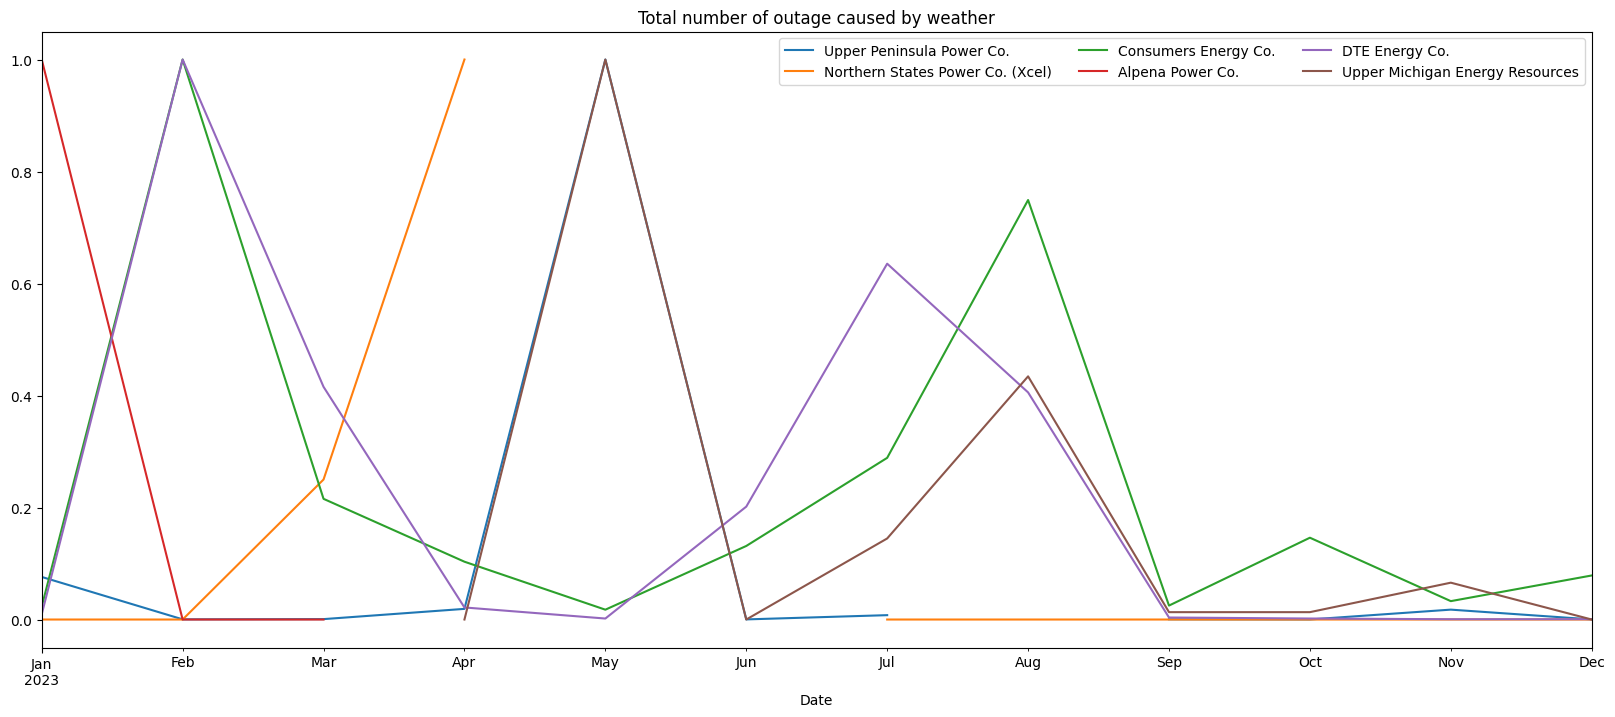

In [10]:
"""
This code snippet visualizes a specific reliability index for different energy systems. It normalizes the data and plots it for each system.

Explanation:
1. The dictionary `fields` maps field IDs to their corresponding descriptions.
2. The variable `field_to_analyze` is set to the description of the reliability index to be analyzed (e.g., SAIFI).
3. A plot is created for each energy system, showing the normalized values of the specified reliability index.
4. The y-axis represents the normalized index values (scaled to a maximum of 1).

Note:
- Adjust the field descriptions and column names according to your specific data.
"""

field_to_analyze: str = fields.get(8)

plt.figure(figsize=(20, 8))

for i in data_co["System"].value_counts().index:
    (data_co[data_co["System"] == i][field_to_analyze] / (data_co[data_co["System"] == i][field_to_analyze].max() or 1)).plot(label=i)
    plt.legend(ncol=3)
    plt.title(label=field_to_analyze)

# TODO: Create a new column with the sum of the fields marked with # THIS

In [12]:
try:
    raw_data = pd.read_csv(os.getenv('FILE_PATH_OMNI'), delimiter=" +", names=range(55), engine="python")
except:
    print("<Exception> OMNI File required")
    exit(0)

In [13]:
"""
This code snippet filters and processes data from a DataFrame. It selects specific columns based on their indices and restricts the data to a specific date range.

Explanation:
1. The DataFrame `raw_data` contains columns with indices 0, 1, 2, 38, 39, 40, 49, 50, 22, 23, 24, 27, 28, and 8.
2. The minimum and maximum dates from the DataFrame `filtered_df` are determined.
3. The years corresponding to these dates are extracted using `pd.Timestamp`.
4. The data is filtered to include only rows where the year (column 0) falls within the specified date range.
5. Column names are assigned to the processed data for better readability.

Note:
- Adjust column indices and date range according to your specific data.
"""

data_omni = raw_data[[0, 1, 2, 38, 39, 40, 49, 50, 22, 23, 24, 27, 28, 8]]
min_date, max_date = data_co.index.min(), data_co.index.max()
min_date_year, max_date_year = pd.Timestamp(min_date).year, pd.Timestamp(max_date).year
filtered_data_omni = data_omni[(data_omni[0] >= min_date_year) & (data_omni[0] <= max_date_year)]

filtered_data_omni.columns = [
    "Year", # 
    "DecimalYear", #
    "Hour", #
    "Kp", #
    "R", #
    "DST", #
    "Ap", #
    "F10.7", #
    "Proton temperature", #
    "Proton density", #
    "Plasma speed", #
    "Alpha/Proton ratio", #
    "Flow Pressure", #
    "Field Magnitude Average |B|" #
]

filtered_data_omni.index = pd.date_range(str(min_date_year), str(max_date_year + 1), freq="60min")[:-1]

filtered_data_omni = filtered_data_omni[["Kp", "R", "DST", "Ap", "F10.7", "Proton temperature", "Proton density", "Plasma speed", "Alpha/Proton ratio", "Flow Pressure", "Field Magnitude Average |B|"]]

In [10]:
"""
Explanation:
1. The DataFrame `data` contains columns that need cleaning.
2. We create a list of column names to process.
3. For each column, we replace specific values with NaN using `np.where`.

Note:
- Adjust column names and replacement values according to your specific data.
"""

columns_to_clean = [
    "F10.7",
    "Kp",
    "R",
    "DST",
    "Ap",
    "Proton temperature",
    "Proton density",
    "Plasma speed",
    "Alpha/Proton ratio",
    "Flow Pressure",
    "Field Magnitude Average |B|"
]

for col in columns_to_clean:
    filtered_data_omni[col] = np.where(filtered_data_omni[col] == 999.9, np.nan,filtered_data_omni[col])
    filtered_data_omni[col] = np.where(filtered_data_omni[col] == 99, np.nan, filtered_data_omni[col])
    filtered_data_omni[col] = np.where(filtered_data_omni[col] == 999, np.nan, filtered_data_omni[col])

In [11]:
filtered_data_omni = filtered_data_omni[(filtered_data_omni.index >= str(min_date_year))]

In [12]:
def create_columns(df: pd.DataFrame, new_columns: typing.Any) -> pd.DataFrame:
    df[new_columns] = np.zeros((len(df), len(new_columns)))
    return df

In [13]:
df: pd.DataFrame = filtered_data_omni.copy()
new_columns_kp: typing.List = ['G0', 'G1 ', 'G2', 'G3', 'G4', 'G5']
df = create_columns(df=df, new_columns=new_columns_kp)

In [14]:
conditions_kp: typing.Dict[str, pd.Series] = {
    'G0': filtered_data_omni['Kp'].le(43),
    'G1': filtered_data_omni['Kp'].between(46, 54),
    'G2': filtered_data_omni['Kp'].between(56, 64),
    'G3': filtered_data_omni['Kp'].between(66, 74),
    'G4': filtered_data_omni['Kp'].between(76, 88),
    'G5': filtered_data_omni['Kp'].ge(90)
}
 
for G, condition in conditions_kp.items():
    df[G] = condition

In [ ]:
conditions_dst = typing.Dict[str, pd.Series] = {
    'Weak': filtered_data_omni['DST'].between(-50, -30, inclusive='right'),
    'Moderate': filtered_data_omni['DST'].between(-100, -50, inclusive='right'),
    # TODO: Implement the rest of the conditions
}

In [15]:
def resample_kp(df: pd.DataFrame, lvl, closed: bool = None) -> pd.DataFrame:
    df_resampled_kp: pd.DataFrame = df.resample(rule=lvl, closed=closed).agg({
        'Kp': 'max',
        'R': 'mean',
        'F10.7': 'mean',
        'Proton temperature': 'mean',
        'Proton density': 'mean',
        'Plasma speed': 'mean',
        'Alpha/Proton ratio': 'mean',
        'Flow Pressure': 'mean',
        'Field Magnitude Average |B|': 'mean',
        'G1': 'sum',
        'G1': 'sum',
        'G2': 'sum',
        'G3': 'sum',
        'G4': 'sum',
        'G5': 'sum'
    })

    df_resampled_kp['Total ST'] = df_resampled_kp[['G1', 'G2', 'G3', 'G4', 'G5']].sum(axis=1)
    return df_resampled_kp

In [ ]:
# TODO: Create a resample_dst function

In [16]:
freq: str = "ME"

In [28]:
df_resample_kp: pd.DataFrame = resample_kp(df, freq)
df_resample_kp['Solar Cycle'] = pd.cut(df_resample_kp.index, 
                                        bins=[
                                            pd.to_datetime('1964-10-01'),
                                            pd.to_datetime('1976-03-01'),
                                            pd.to_datetime('1986-09-01'),
                                            pd.to_datetime("1996-08-01"), 
                                            pd.to_datetime("2008-12-31"),
                                            pd.to_datetime("2019-12-31"), 
                                            pd.to_datetime("2100-01-01")
                                        ],
                                        labels=[20, 21, 22, 23, 24, 25])

df_resample_kp = df_resample_kp.rename(columns={"Kp": "Kp max"})

In [27]:
def assign_columns(df: pd.DataFrame, columns_to_assign: typing.List[str]) -> pd.DataFrame:
    for col in columns_to_assign:
        df = df.assign(**{col.strip(): df_resample_kp[col.strip()]})

    return df

In [ ]:
c1_CEC: pd.DataFrame = filtered_df_co[filtered_df_co["System"] == desired_systems.get(1)]
c1_CEC = assign_columns(df=c1_CEC.copy(), columns_to_assign=['Total ST', 'G1', 'G2', 'G3', 'G4', 'G5'])

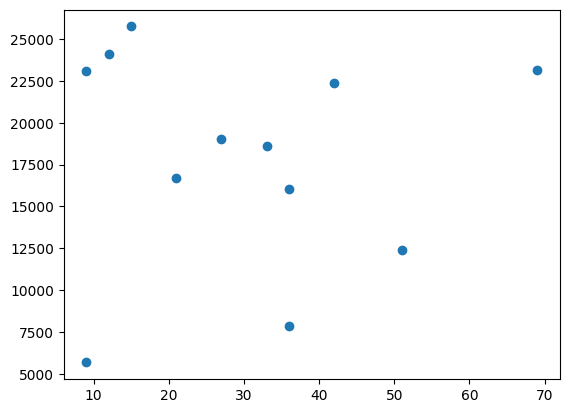

In [32]:
plt.scatter(c1_CEC['Total ST'], c1_CEC[field_to_analyze])

Text(0.5, 1.0, 'Total Storms vs Total number of outages caused by unknonwn causes')

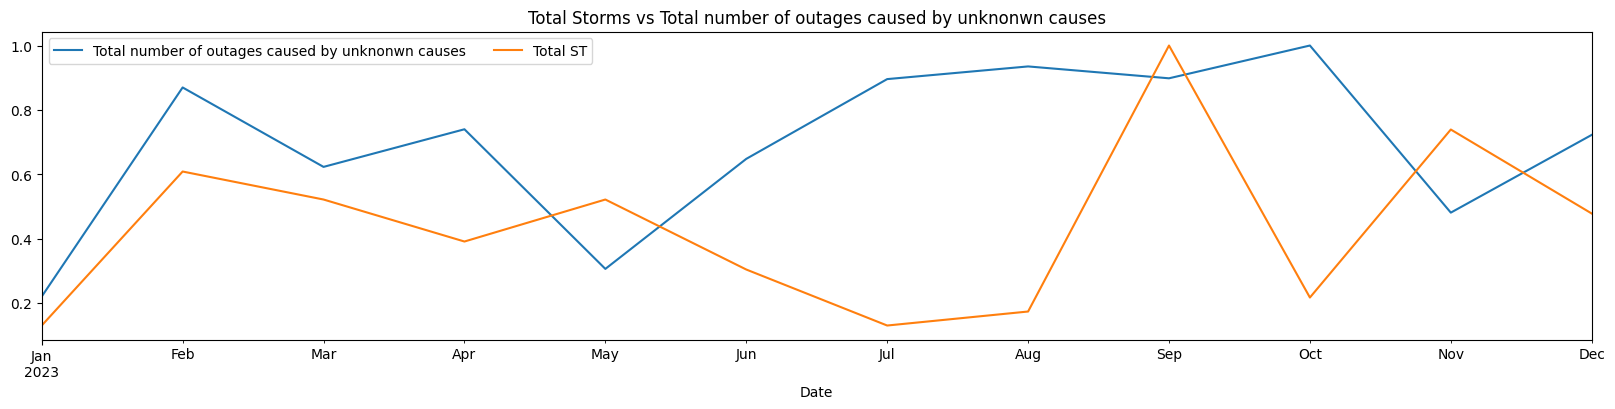

In [34]:
plt.figure(figsize=(20, 4))
(c1_CEC[field_to_analyze] / c1_CEC[field_to_analyze].max()).plot()
(c1_CEC['Total ST'] / c1_CEC['Total ST'].max()).plot()
plt.legend(ncol=3)
plt.title(label=f"Total Storms vs {field_to_analyze}")

In [35]:
np.corrcoef(np.array(c1_CEC[field_to_analyze]).astype(dtype=float), np.array(c1_CEC['Total ST']).astype(dtype=float))

array([[ 1.00000000e+00, -2.36368591e-04],
       [-2.36368591e-04,  1.00000000e+00]])

In [36]:
c1_CEC.corr(numeric_only=True)

,Total ST,G1,G2,G3,G4,G5
Total ST,1.000000e+00,0.853123,0.792076,0.330489,4.716769e-18,NaN
G1,8.531227e-01,1.000000,0.442705,-0.171458,-3.022045e-01,NaN
G2,7.920762e-01,0.442705,1.000000,0.518200,-3.512919e-02,NaN
G3,3.304895e-01,-0.171458,0.518200,1.000000,6.507914e-01,NaN
G4,4.716769e-18,-0.302205,-0.035129,0.650791,1.000000e+00,NaN
G5,NaN,NaN,NaN,NaN,NaN,NaN
